In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import struct
import torch.utils.data as Data
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torchsummary import summary

myFont = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}

In [2]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.LeakyReLU(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid() 
        )
 
    def forward(self, x):
        x = self.fc1(x.view(x.size(0),-1))
        mid_out = self.fc2(x)
        x = self.fc3(mid_out)
        return x, mid_out

netD = Discriminator()
# summary(netD, (1,28,28))  

In [3]:
torch.cuda.is_available()

True

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(True),
            nn.Linear(256, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Tanh()
        )
 
    def forward(self, x):
        x = self.gen(x)
        return x

netG = Generator()
# summary(netG, (100,)) 

In [5]:
if torch.cuda.is_available():
    netD = netD.cuda()
    netG = netG.cuda()

In [6]:
criterion = nn.BCELoss()
D_optimizer = torch.optim.Adam(netD.parameters(), lr=0.0003)
G_optimizer = torch.optim.Adam(netG.parameters(), lr=0.0003)

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_train = datasets.MNIST(root = "./data/",
                            transform = transform,
                            train = True,
                            download = True)

data_test = datasets.MNIST(root="./data/",
                           transform = transform,
                           train = False)

data_loader_train = torch.utils.data.DataLoader(dataset=data_train,
                                                batch_size = 64,
                                                shuffle = True)

data_loader_test = torch.utils.data.DataLoader(dataset=data_test,
                                               batch_size = 64,
                                               shuffle = True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [8]:
epochs = 150
D_losslist = []
G_losslist = []

for epoch in range(epochs):
    for inputs, _ in data_loader_train:
        n = inputs.size(0)

        inputs = inputs.cuda()
        real_label = torch.ones(n).cuda()
        fake_label = torch.zeros(n).cuda() 
        '''
        train discriminator
        '''
        real_out, _ = netD(inputs)
        real_out = real_out.squeeze()
        D_loss_real = criterion(real_out, real_label)
        noise = torch.randn(n, 100).cuda()
        fake_inputs = netG(noise).detach()
        fake_out, _ = netD(fake_inputs)
        fake_out = fake_out.squeeze()
        D_loss_fake = criterion(fake_out, fake_label)
        D_loss = D_loss_real + D_loss_fake
        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()
        '''
        train generator
        '''
        noise = torch.randn(n, 100).cuda()
        fake_img = netG(noise)
        output, _ = netD(fake_img)
        output = output.squeeze()
        G_loss = criterion(output, real_label) 
        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

    print('epoch ',epoch+1,
          'Discriminator loss: ', D_loss.item(),
          'Generator loss: ', G_loss.item())
    D_losslist.append(D_loss.item())
    G_losslist.append(G_loss.item())

epoch  1 Discriminator loss:  0.165897399187088 Generator loss:  5.931334972381592
epoch  2 Discriminator loss:  0.386024534702301 Generator loss:  2.5783185958862305
epoch  3 Discriminator loss:  0.7518300414085388 Generator loss:  2.4869487285614014
epoch  4 Discriminator loss:  0.38890206813812256 Generator loss:  2.3132519721984863
epoch  5 Discriminator loss:  0.39749008417129517 Generator loss:  4.820300102233887
epoch  6 Discriminator loss:  0.7464389204978943 Generator loss:  4.109537601470947
epoch  7 Discriminator loss:  0.28069794178009033 Generator loss:  4.608328342437744
epoch  8 Discriminator loss:  0.19898483157157898 Generator loss:  2.6176695823669434
epoch  9 Discriminator loss:  0.43705809116363525 Generator loss:  4.892414569854736
epoch  10 Discriminator loss:  0.421959787607193 Generator loss:  2.504131317138672
epoch  11 Discriminator loss:  0.5456486344337463 Generator loss:  3.721296787261963
epoch  12 Discriminator loss:  0.4229961037635803 Generator loss:  2

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


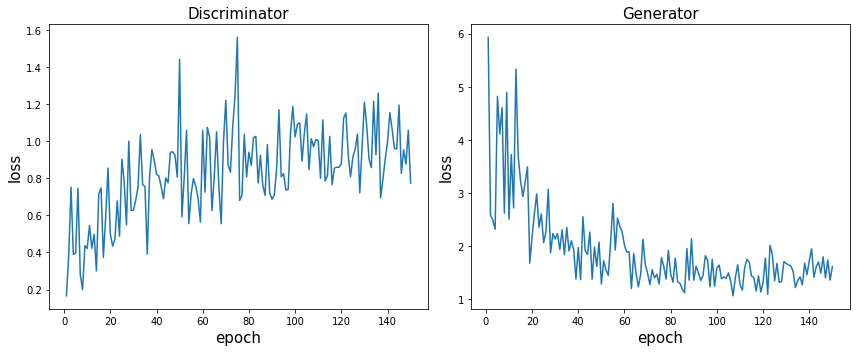

In [9]:
fig = plt.figure(figsize=(12,5))
fig.add_subplot(1,2,1)
plt.plot(range(1,epochs+1), D_losslist)
plt.xlabel('epoch', myFont)
plt.ylabel('loss', myFont)
plt.title('Discriminator', myFont)
fig.add_subplot(1,2,2)
plt.plot(range(1,epochs+1), G_losslist)
plt.xlabel('epoch', myFont)
plt.ylabel('loss', myFont)
plt.title('Generator', myFont)
plt.tight_layout()
plt.show()

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
np.save('/content/drive/MyDrive/D_losslist',D_losslist)
np.save('/content/drive/MyDrive/G_losslist',G_losslist)

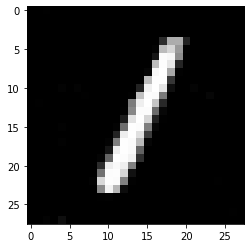

In [20]:
test_img = netG(torch.randn(1, 100).cuda()).view((28,28))
plt.imshow(test_img.detach().cpu(), cmap='gray')

In [34]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(True),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(True),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(64,10),
            nn.Softmax()
        )
    def forward(self, x):
        _, x = netD(x)
        x = x.detach()
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.003)
if torch.cuda.is_available():
    net = net.cuda()

In [35]:
epochs = 100

for epoch in range(epochs):
    for inputs, labels in data_loader_train:
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch ', epoch, ' loss : ', loss.item(), sep='')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 0 loss : 1.5742216110229492
epoch 1 loss : 1.5830483436584473
epoch 2 loss : 1.4924147129058838
epoch 3 loss : 1.6486519575119019
epoch 4 loss : 1.4924007654190063
epoch 5 loss : 1.6171109676361084
epoch 6 loss : 1.4611507654190063
epoch 7 loss : 1.617060899734497
epoch 8 loss : 1.4924007654190063
epoch 9 loss : 1.5236507654190063
epoch 10 loss : 1.4924007654190063
epoch 11 loss : 1.5549007654190063
epoch 12 loss : 1.554900884628296
epoch 13 loss : 1.5236507654190063
epoch 14 loss : 1.5236507654190063
epoch 15 loss : 1.4924007654190063
epoch 16 loss : 1.4924007654190063
epoch 17 loss : 1.5549007654190063
epoch 18 loss : 1.461151361465454
epoch 19 loss : 1.6799007654190063
epoch 20 loss : 1.5236507654190063
epoch 21 loss : 1.5861507654190063
epoch 22 loss : 1.5236507654190063
epoch 23 loss : 1.4611507654190063
epoch 24 loss : 1.5236488580703735
epoch 25 loss : 1.5549007654190063
epoch 26 loss : 1.4924007654190063
epoch 27 loss : 1.5549007654190063
epoch 28 loss : 1.461150765419006

In [36]:
total = 0
correct = 0
for inputs, labels in data_loader_test:
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Accuracy of the network on test images: 93.67 %
